# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -1.291668 -1.301982  1.0  0.442705 -0.254098  1.815137  2  2  23.247617   
1 -0.995206 -2.149631  0.0  0.203038  2.495324 -0.453060  1  3  19.792493   
2 -0.840319 -1.338842  0.0  0.918871  1.827131  1.055123  1  3  26.227977   
3 -1.969761 -0.505264  1.0  0.334754 -0.973954  1.391490  3  3  21.184687   
4 -1.283567 -0.402781  1.0  0.587197  0.076717  0.560620  2  1  24.283443   

            y  
0   21.594318  
1  -50.073190  
2   48.436194  
3   79.581436  
4  135.551598  
True causal estimate is 6.601609531850172


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

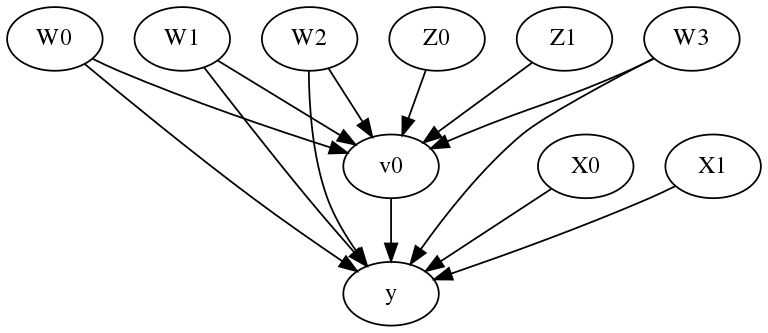

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W0,W3,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W2,U) = P(y|v0,W1,W0,W3,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

linear_regression


{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['X1', 'X0']}


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W0,W3,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W2,U) = P(y|v0,W1,W0,W3,W2)

## Realized estimand
b: y~v0+W1+W0+W3+W2+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 6.601671569895878
### Conditional Estimates
__categorical__X1  __categorical__X0
(-3.933, -1.24]    (-4.609, -1.527]     -3.347521
                   (-1.527, -0.932]     -1.696399
                   (-0.932, -0.426]     -0.730244
                   (-0.426, 0.157]       0.300496
                   (0.157, 3.585]        1.931630
(-1.24, -0.662]    (-4.609, -1.527]      1.055801
                   (-1.527, -0.932]      2.746536
                   (-0.932, -0.426]      3.831789
                   (-0.426, 0.157]       4.797191
                  

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

2022-03-20 20:02:05.494922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-20 20:02:05.495147: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W0,W3,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W2,U) = P(y|v0,W1,W0,W3,W2)

## Realized estimand
b: y~v0+W1+W0+W3+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 10.70062371128781
Effect estimates: [ 1.31524076e+01  1.58870712e+01  1.08598304e+01  6.19575785e+00
  1.40199717e+01  1.89274064e+01 -5.65504202e-03  1.00123854e+01
  1.46016481e+01  6.90141813e+00  9.52702249e+00  1.60284217e+01
  6.29759273e+00  8.13813839e+00  2.90371347e+00  9.26071667e+00
  2.03721778e+01  1.57468869e+01  8.09625280e+00  3.33755520e+00
  1.05444164e+01  8.14302438e+00  1.17421444e+01  9.94336914e+00
  1.24578498e+01  1.48674830e+01  6.89061325e+00  8.55289085e+00
  1.58456491e+01  1.27242952e+01

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 6.601609531850172


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W0,W3,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W2,U) = P(y|v0,W1,W0,W3,W2)

## Realized estimand
b: y~v0+W1+W0+W3+W2 | X1,X0
Target units: 

## Estimate
Mean value: 6.571814407969316
Effect estimates: [ 0.59219414 -3.28708898  1.29891038 ...  4.53787046 11.3932491
  4.89947929]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W0,W3,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W2,U) = P(y|v0,W1,W0,W3,W2)

## Realized estimand
b: y~v0+W1+W0+W3+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 6.587024800191513
Effect estimates: [ 0.67970883 -3.2002392   1.3518714  ...  4.60481978 11.44207472
  4.85362156]
95.0% confidence interval: (array([ 0.57481707, -3.53135959,  1.22651968, ...,  4.62773199,
       11.59284679,  4.75761518]), array([ 0.78623195, -3.14073953,  1.44226214, ...,  4.78956125,
       11.967764  ,  5.00791026]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[14.97205939 13.93136392 13.09642566 14.45131149 15.93141245 11.2642044
 12.28229185 11.80694714 11.56509294 12.80136525]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -1.631403  0.864561  1.0  0.472050  0.463866  1.056543 -0.850493   
1    -0.677137  1.575165  1.0  0.302314 -0.008876 -1.517811 -0.761076   
2     0.123929 -0.056822  1.0  0.380663 -0.942578  0.587939 -0.620685   
3    -0.463416 -0.099464  1.0  0.671285  0.214960  2.107793 -0.215950   
4    -0.399806  0.350352  0.0  0.934399  1.337868  0.408679 -0.839020   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.413922  2.390794  1.0  0.150376  0.487912 -0.517278 -1.835885   
9996 -0.709928  0.061320  0.0  0.675363  1.311472 -0.493994 -1.475204   
9997 -1.539903  1.840717  1.0  0.378536  1.840798 -1.046403 -1.483989   
9998  0.782836  2.570484  1.0  0.672002  0.830892  1.283037 -0.644771   
9999  1.795542  0.711056  1.0  0.843653 -0.180631 -0.659098 -1.397798   

            W3  v0  y  
0    -2.080035   1  0  
1    -0.251091   1  1  
2     0.892422   1  1  
3     0.694462   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W0,W3,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W2,U) = P(y|v0,W1,W0,W3,W2)

## Realized estimand
b: y~v0+W1+W0+W3+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 0.47147382373859026
Effect estimates: [0.42575361 0.49912159 0.48965645 ... 0.46174013 0.60844145 0.60297128]

True causal estimate is 0.4398


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-03-20 20:03:49.050031: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-20 20:03:49.050251: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-20 20:03:49.050444: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (AMSHAR-Z840): /proc/driver/nvidia/version does not exist
2022-03-20 20:03:49.051087: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 3:53 - loss: 192.6535

 15/313 [>.............................] - ETA: 1s - loss: 108.8618  

 31/313 [=>............................] - ETA: 0s - loss: 62.1325 

 49/313 [===>..........................] - ETA: 0s - loss: 41.5365

 67/313 [=====>........................] - ETA: 0s - loss: 31.8424

 85/313 [=======>......................] - ETA: 0s - loss: 26.1778

102/313 [========>.....................] - ETA: 0s - loss: 22.6503

121/313 [==========>...................] - ETA: 0s - loss: 19.8617

139/313 [============>.................] - ETA: 0s - loss: 17.9014

157/313 [==============>...............] - ETA: 0s - loss: 16.3759

176/313 [===============>..............] - ETA: 0s - loss: 15.1227

195/313 [=================>............] - ETA: 0s - loss: 14.0914

213/313 [===================>..........] - ETA: 0s - loss: 13.2826

231/313 [=====================>........] - ETA: 0s - loss: 12.5970

249/313 [======================>.......] - ETA: 0s - loss: 12.0069

267/313 [========================>.....] - ETA: 0s - loss: 11.4980

285/313 [==========================>...] - ETA: 0s - loss: 11.0560

304/313 [============================>.] - ETA: 0s - loss: 10.6379

313/313 [==============================] - 2s 3ms/step - loss: 10.4595


Epoch 2/25
  1/313 [..............................] - ETA: 1s - loss: 4.1983

 19/313 [>.............................] - ETA: 0s - loss: 4.2988

 37/313 [==>...........................] - ETA: 0s - loss: 4.3450

 55/313 [====>.........................] - ETA: 0s - loss: 4.3196

 72/313 [=====>........................] - ETA: 0s - loss: 4.3029

 90/313 [=======>......................] - ETA: 0s - loss: 4.2949

108/313 [=========>....................] - ETA: 0s - loss: 4.2914

126/313 [===========>..................] - ETA: 0s - loss: 4.2860

143/313 [============>.................] - ETA: 0s - loss: 4.2691

161/313 [==============>...............] - ETA: 0s - loss: 4.2586

178/313 [================>.............] - ETA: 0s - loss: 4.2478

194/313 [=================>............] - ETA: 0s - loss: 4.2440

213/313 [===================>..........] - ETA: 0s - loss: 4.2314

231/313 [=====================>........] - ETA: 0s - loss: 4.2283

250/313 [======================>.......] - ETA: 0s - loss: 4.2138

269/313 [========================>.....] - ETA: 0s - loss: 4.2034

288/313 [==========================>...] - ETA: 0s - loss: 4.1907

307/313 [============================>.] - ETA: 0s - loss: 4.1845

313/313 [==============================] - 1s 3ms/step - loss: 4.1793


Epoch 3/25
  1/313 [..............................] - ETA: 0s - loss: 3.7844

 20/313 [>.............................] - ETA: 0s - loss: 3.9595

 39/313 [==>...........................] - ETA: 0s - loss: 3.9444

 58/313 [====>.........................] - ETA: 0s - loss: 3.9322

 77/313 [======>.......................] - ETA: 0s - loss: 3.9131

 95/313 [========>.....................] - ETA: 0s - loss: 3.9000

113/313 [=========>....................] - ETA: 0s - loss: 3.8913

132/313 [===========>..................] - ETA: 0s - loss: 3.8644

151/313 [=============>................] - ETA: 0s - loss: 3.8404

170/313 [===============>..............] - ETA: 0s - loss: 3.8206

188/313 [=================>............] - ETA: 0s - loss: 3.7882

207/313 [==================>...........] - ETA: 0s - loss: 3.7471

226/313 [====================>.........] - ETA: 0s - loss: 3.7020

244/313 [======================>.......] - ETA: 0s - loss: 3.6537

263/313 [========================>.....] - ETA: 0s - loss: 3.6047

282/313 [==========================>...] - ETA: 0s - loss: 3.5640

301/313 [===========================>..] - ETA: 0s - loss: 3.5268

313/313 [==============================] - 1s 3ms/step - loss: 3.5068


Epoch 4/25
  1/313 [..............................] - ETA: 1s - loss: 2.8575

 19/313 [>.............................] - ETA: 0s - loss: 2.9382

 37/313 [==>...........................] - ETA: 0s - loss: 2.9110

 55/313 [====>.........................] - ETA: 0s - loss: 2.9046

 74/313 [======>.......................] - ETA: 0s - loss: 2.9025

 93/313 [=======>......................] - ETA: 0s - loss: 2.8941

112/313 [=========>....................] - ETA: 0s - loss: 2.9025

131/313 [===========>..................] - ETA: 0s - loss: 2.8896

150/313 [=============>................] - ETA: 0s - loss: 2.8757

168/313 [===============>..............] - ETA: 0s - loss: 2.8707

186/313 [================>.............] - ETA: 0s - loss: 2.8665

205/313 [==================>...........] - ETA: 0s - loss: 2.8658

224/313 [====================>.........] - ETA: 0s - loss: 2.8603

243/313 [======================>.......] - ETA: 0s - loss: 2.8531

261/313 [========================>.....] - ETA: 0s - loss: 2.8499

280/313 [=========================>....] - ETA: 0s - loss: 2.8484

299/313 [===========================>..] - ETA: 0s - loss: 2.8430

313/313 [==============================] - 1s 3ms/step - loss: 2.8420


Epoch 5/25
  1/313 [..............................] - ETA: 0s - loss: 2.5714

 19/313 [>.............................] - ETA: 0s - loss: 2.7664

 37/313 [==>...........................] - ETA: 0s - loss: 2.7799

 56/313 [====>.........................] - ETA: 0s - loss: 2.7598

 74/313 [======>.......................] - ETA: 0s - loss: 2.7628

 93/313 [=======>......................] - ETA: 0s - loss: 2.7672

112/313 [=========>....................] - ETA: 0s - loss: 2.7731

131/313 [===========>..................] - ETA: 0s - loss: 2.7725

150/313 [=============>................] - ETA: 0s - loss: 2.7744

168/313 [===============>..............] - ETA: 0s - loss: 2.7664

187/313 [================>.............] - ETA: 0s - loss: 2.7687

206/313 [==================>...........] - ETA: 0s - loss: 2.7670

225/313 [====================>.........] - ETA: 0s - loss: 2.7703

244/313 [======================>.......] - ETA: 0s - loss: 2.7707

264/313 [========================>.....] - ETA: 0s - loss: 2.7709

282/313 [==========================>...] - ETA: 0s - loss: 2.7747

300/313 [===========================>..] - ETA: 0s - loss: 2.7710

313/313 [==============================] - 1s 3ms/step - loss: 2.7721


Epoch 6/25
  1/313 [..............................] - ETA: 1s - loss: 2.7729

 20/313 [>.............................] - ETA: 0s - loss: 2.7223

 40/313 [==>...........................] - ETA: 0s - loss: 2.7090

 59/313 [====>.........................] - ETA: 0s - loss: 2.7137

 78/313 [======>.......................] - ETA: 0s - loss: 2.7134

 97/313 [========>.....................] - ETA: 0s - loss: 2.7121

116/313 [==========>...................] - ETA: 0s - loss: 2.7090

135/313 [===========>..................] - ETA: 0s - loss: 2.7095

155/313 [=============>................] - ETA: 0s - loss: 2.7100

174/313 [===============>..............] - ETA: 0s - loss: 2.7070

194/313 [=================>............] - ETA: 0s - loss: 2.7063

214/313 [===================>..........] - ETA: 0s - loss: 2.7047

233/313 [=====================>........] - ETA: 0s - loss: 2.7040

252/313 [=======================>......] - ETA: 0s - loss: 2.6994

272/313 [=========================>....] - ETA: 0s - loss: 2.6994

291/313 [==========================>...] - ETA: 0s - loss: 2.6965

310/313 [============================>.] - ETA: 0s - loss: 2.6926

313/313 [==============================] - 1s 3ms/step - loss: 2.6916


Epoch 7/25
  1/313 [..............................] - ETA: 1s - loss: 2.5908

 20/313 [>.............................] - ETA: 0s - loss: 2.6252

 39/313 [==>...........................] - ETA: 0s - loss: 2.6450

 59/313 [====>.........................] - ETA: 0s - loss: 2.6521

 79/313 [======>.......................] - ETA: 0s - loss: 2.6717

 98/313 [========>.....................] - ETA: 0s - loss: 2.6725

117/313 [==========>...................] - ETA: 0s - loss: 2.6748

136/313 [============>.................] - ETA: 0s - loss: 2.6733

156/313 [=============>................] - ETA: 0s - loss: 2.6743

175/313 [===============>..............] - ETA: 0s - loss: 2.6767

195/313 [=================>............] - ETA: 0s - loss: 2.6806

213/313 [===================>..........] - ETA: 0s - loss: 2.6807

232/313 [=====================>........] - ETA: 0s - loss: 2.6786

251/313 [=======================>......] - ETA: 0s - loss: 2.6741

269/313 [========================>.....] - ETA: 0s - loss: 2.6738

288/313 [==========================>...] - ETA: 0s - loss: 2.6704

307/313 [============================>.] - ETA: 0s - loss: 2.6728

313/313 [==============================] - 1s 3ms/step - loss: 2.6720


Epoch 8/25
  1/313 [..............................] - ETA: 0s - loss: 2.6463

 19/313 [>.............................] - ETA: 0s - loss: 2.6079

 38/313 [==>...........................] - ETA: 0s - loss: 2.6467

 57/313 [====>.........................] - ETA: 0s - loss: 2.6434

 76/313 [======>.......................] - ETA: 0s - loss: 2.6419

 95/313 [========>.....................] - ETA: 0s - loss: 2.6298

114/313 [=========>....................] - ETA: 0s - loss: 2.6278

134/313 [===========>..................] - ETA: 0s - loss: 2.6356

153/313 [=============>................] - ETA: 0s - loss: 2.6340

172/313 [===============>..............] - ETA: 0s - loss: 2.6249

191/313 [=================>............] - ETA: 0s - loss: 2.6208

211/313 [===================>..........] - ETA: 0s - loss: 2.6182

230/313 [=====================>........] - ETA: 0s - loss: 2.6113

249/313 [======================>.......] - ETA: 0s - loss: 2.6093

268/313 [========================>.....] - ETA: 0s - loss: 2.6051

287/313 [==========================>...] - ETA: 0s - loss: 2.6021

307/313 [============================>.] - ETA: 0s - loss: 2.5968

313/313 [==============================] - 1s 3ms/step - loss: 2.5943


Epoch 9/25
  1/313 [..............................] - ETA: 1s - loss: 2.3508

 20/313 [>.............................] - ETA: 0s - loss: 2.5377

 39/313 [==>...........................] - ETA: 0s - loss: 2.5483

 58/313 [====>.........................] - ETA: 0s - loss: 2.5453

 77/313 [======>.......................] - ETA: 0s - loss: 2.5505

 96/313 [========>.....................] - ETA: 0s - loss: 2.5499

115/313 [==========>...................] - ETA: 0s - loss: 2.5472

134/313 [===========>..................] - ETA: 0s - loss: 2.5465

153/313 [=============>................] - ETA: 0s - loss: 2.5415

172/313 [===============>..............] - ETA: 0s - loss: 2.5475

191/313 [=================>............] - ETA: 0s - loss: 2.5371

210/313 [===================>..........] - ETA: 0s - loss: 2.5392

229/313 [====================>.........] - ETA: 0s - loss: 2.5361

248/313 [======================>.......] - ETA: 0s - loss: 2.5321

267/313 [========================>.....] - ETA: 0s - loss: 2.5274

287/313 [==========================>...] - ETA: 0s - loss: 2.5245

306/313 [============================>.] - ETA: 0s - loss: 2.5268

313/313 [==============================] - 1s 3ms/step - loss: 2.5251


Epoch 10/25
  1/313 [..............................] - ETA: 0s - loss: 2.3654

 20/313 [>.............................] - ETA: 0s - loss: 2.5507

 39/313 [==>...........................] - ETA: 0s - loss: 2.5145

 58/313 [====>.........................] - ETA: 0s - loss: 2.5163

 77/313 [======>.......................] - ETA: 0s - loss: 2.5083

 96/313 [========>.....................] - ETA: 0s - loss: 2.5071

115/313 [==========>...................] - ETA: 0s - loss: 2.4945

135/313 [===========>..................] - ETA: 0s - loss: 2.4996

154/313 [=============>................] - ETA: 0s - loss: 2.5030

174/313 [===============>..............] - ETA: 0s - loss: 2.5023

194/313 [=================>............] - ETA: 0s - loss: 2.5031

213/313 [===================>..........] - ETA: 0s - loss: 2.5002

232/313 [=====================>........] - ETA: 0s - loss: 2.4972

252/313 [=======================>......] - ETA: 0s - loss: 2.4962

271/313 [========================>.....] - ETA: 0s - loss: 2.4940

290/313 [==========================>...] - ETA: 0s - loss: 2.4938

309/313 [============================>.] - ETA: 0s - loss: 2.4945

313/313 [==============================] - 1s 3ms/step - loss: 2.4947


Epoch 11/25
  1/313 [..............................] - ETA: 0s - loss: 2.3523

 21/313 [=>............................] - ETA: 0s - loss: 2.5036

 40/313 [==>...........................] - ETA: 0s - loss: 2.4882

 59/313 [====>.........................] - ETA: 0s - loss: 2.4792

 78/313 [======>.......................] - ETA: 0s - loss: 2.4656

 98/313 [========>.....................] - ETA: 0s - loss: 2.4697

117/313 [==========>...................] - ETA: 0s - loss: 2.4697

136/313 [============>.................] - ETA: 0s - loss: 2.4661

155/313 [=============>................] - ETA: 0s - loss: 2.4722

174/313 [===============>..............] - ETA: 0s - loss: 2.4711

194/313 [=================>............] - ETA: 0s - loss: 2.4659

213/313 [===================>..........] - ETA: 0s - loss: 2.4679

232/313 [=====================>........] - ETA: 0s - loss: 2.4697

252/313 [=======================>......] - ETA: 0s - loss: 2.4672

271/313 [========================>.....] - ETA: 0s - loss: 2.4661

290/313 [==========================>...] - ETA: 0s - loss: 2.4660

309/313 [============================>.] - ETA: 0s - loss: 2.4637

313/313 [==============================] - 1s 3ms/step - loss: 2.4635


Epoch 12/25
  1/313 [..............................] - ETA: 1s - loss: 2.5238

 20/313 [>.............................] - ETA: 0s - loss: 2.4675

 39/313 [==>...........................] - ETA: 0s - loss: 2.4653

 58/313 [====>.........................] - ETA: 0s - loss: 2.4701

 78/313 [======>.......................] - ETA: 0s - loss: 2.4664

 97/313 [========>.....................] - ETA: 0s - loss: 2.4590

117/313 [==========>...................] - ETA: 0s - loss: 2.4608

136/313 [============>.................] - ETA: 0s - loss: 2.4568

155/313 [=============>................] - ETA: 0s - loss: 2.4601

174/313 [===============>..............] - ETA: 0s - loss: 2.4619

193/313 [=================>............] - ETA: 0s - loss: 2.4577

212/313 [===================>..........] - ETA: 0s - loss: 2.4493

232/313 [=====================>........] - ETA: 0s - loss: 2.4434

251/313 [=======================>......] - ETA: 0s - loss: 2.4450

271/313 [========================>.....] - ETA: 0s - loss: 2.4451

290/313 [==========================>...] - ETA: 0s - loss: 2.4435

309/313 [============================>.] - ETA: 0s - loss: 2.4431

313/313 [==============================] - 1s 3ms/step - loss: 2.4441


Epoch 13/25
  1/313 [..............................] - ETA: 1s - loss: 2.1745

 20/313 [>.............................] - ETA: 0s - loss: 2.4610

 39/313 [==>...........................] - ETA: 0s - loss: 2.4410

 58/313 [====>.........................] - ETA: 0s - loss: 2.4526

 77/313 [======>.......................] - ETA: 0s - loss: 2.4380

 96/313 [========>.....................] - ETA: 0s - loss: 2.4327

115/313 [==========>...................] - ETA: 0s - loss: 2.4308

134/313 [===========>..................] - ETA: 0s - loss: 2.4320

153/313 [=============>................] - ETA: 0s - loss: 2.4275

172/313 [===============>..............] - ETA: 0s - loss: 2.4332

191/313 [=================>............] - ETA: 0s - loss: 2.4341

210/313 [===================>..........] - ETA: 0s - loss: 2.4352

229/313 [====================>.........] - ETA: 0s - loss: 2.4355

248/313 [======================>.......] - ETA: 0s - loss: 2.4371

267/313 [========================>.....] - ETA: 0s - loss: 2.4345

286/313 [==========================>...] - ETA: 0s - loss: 2.4373

305/313 [============================>.] - ETA: 0s - loss: 2.4382

313/313 [==============================] - 1s 3ms/step - loss: 2.4370


Epoch 14/25
  1/313 [..............................] - ETA: 1s - loss: 2.7178

 20/313 [>.............................] - ETA: 0s - loss: 2.4321

 39/313 [==>...........................] - ETA: 0s - loss: 2.4175

 58/313 [====>.........................] - ETA: 0s - loss: 2.4208

 78/313 [======>.......................] - ETA: 0s - loss: 2.4199

 97/313 [========>.....................] - ETA: 0s - loss: 2.4164

116/313 [==========>...................] - ETA: 0s - loss: 2.4203

136/313 [============>.................] - ETA: 0s - loss: 2.4256

155/313 [=============>................] - ETA: 0s - loss: 2.4219

174/313 [===============>..............] - ETA: 0s - loss: 2.4183

193/313 [=================>............] - ETA: 0s - loss: 2.4267

212/313 [===================>..........] - ETA: 0s - loss: 2.4245

231/313 [=====================>........] - ETA: 0s - loss: 2.4208

250/313 [======================>.......] - ETA: 0s - loss: 2.4239

269/313 [========================>.....] - ETA: 0s - loss: 2.4234

288/313 [==========================>...] - ETA: 0s - loss: 2.4219

307/313 [============================>.] - ETA: 0s - loss: 2.4242

313/313 [==============================] - 1s 3ms/step - loss: 2.4240


Epoch 15/25
  1/313 [..............................] - ETA: 1s - loss: 2.3155

 21/313 [=>............................] - ETA: 0s - loss: 2.4002

 41/313 [==>...........................] - ETA: 0s - loss: 2.4188

 61/313 [====>.........................] - ETA: 0s - loss: 2.4142

 80/313 [======>.......................] - ETA: 0s - loss: 2.4144

 99/313 [========>.....................] - ETA: 0s - loss: 2.4187

118/313 [==========>...................] - ETA: 0s - loss: 2.4181

137/313 [============>.................] - ETA: 0s - loss: 2.4192

156/313 [=============>................] - ETA: 0s - loss: 2.4230

175/313 [===============>..............] - ETA: 0s - loss: 2.4219

194/313 [=================>............] - ETA: 0s - loss: 2.4170

214/313 [===================>..........] - ETA: 0s - loss: 2.4162

233/313 [=====================>........] - ETA: 0s - loss: 2.4161

252/313 [=======================>......] - ETA: 0s - loss: 2.4158

271/313 [========================>.....] - ETA: 0s - loss: 2.4185

290/313 [==========================>...] - ETA: 0s - loss: 2.4162

310/313 [============================>.] - ETA: 0s - loss: 2.4170

313/313 [==============================] - 1s 3ms/step - loss: 2.4166


Epoch 16/25
  1/313 [..............................] - ETA: 1s - loss: 2.2287

 20/313 [>.............................] - ETA: 0s - loss: 2.4519

 39/313 [==>...........................] - ETA: 0s - loss: 2.4281

 58/313 [====>.........................] - ETA: 0s - loss: 2.4240

 78/313 [======>.......................] - ETA: 0s - loss: 2.4068

 97/313 [========>.....................] - ETA: 0s - loss: 2.4103

116/313 [==========>...................] - ETA: 0s - loss: 2.4114

135/313 [===========>..................] - ETA: 0s - loss: 2.4143

154/313 [=============>................] - ETA: 0s - loss: 2.4103

174/313 [===============>..............] - ETA: 0s - loss: 2.4130

194/313 [=================>............] - ETA: 0s - loss: 2.4166

213/313 [===================>..........] - ETA: 0s - loss: 2.4176

232/313 [=====================>........] - ETA: 0s - loss: 2.4136

251/313 [=======================>......] - ETA: 0s - loss: 2.4117

270/313 [========================>.....] - ETA: 0s - loss: 2.4104

289/313 [==========================>...] - ETA: 0s - loss: 2.4124

308/313 [============================>.] - ETA: 0s - loss: 2.4105

313/313 [==============================] - 1s 3ms/step - loss: 2.4097


Epoch 17/25
  1/313 [..............................] - ETA: 1s - loss: 2.4204

 20/313 [>.............................] - ETA: 0s - loss: 2.4381

 39/313 [==>...........................] - ETA: 0s - loss: 2.4252

 58/313 [====>.........................] - ETA: 0s - loss: 2.4044

 76/313 [======>.......................] - ETA: 0s - loss: 2.4056

 95/313 [========>.....................] - ETA: 0s - loss: 2.4132

115/313 [==========>...................] - ETA: 0s - loss: 2.4071

134/313 [===========>..................] - ETA: 0s - loss: 2.4012

152/313 [=============>................] - ETA: 0s - loss: 2.4021

171/313 [===============>..............] - ETA: 0s - loss: 2.3910

190/313 [=================>............] - ETA: 0s - loss: 2.3878

209/313 [===================>..........] - ETA: 0s - loss: 2.3879

228/313 [====================>.........] - ETA: 0s - loss: 2.3874

247/313 [======================>.......] - ETA: 0s - loss: 2.3861

266/313 [========================>.....] - ETA: 0s - loss: 2.3884

286/313 [==========================>...] - ETA: 0s - loss: 2.3913

305/313 [============================>.] - ETA: 0s - loss: 2.3937

313/313 [==============================] - 1s 3ms/step - loss: 2.3939


Epoch 18/25
  1/313 [..............................] - ETA: 0s - loss: 2.7264

 21/313 [=>............................] - ETA: 0s - loss: 2.4500

 40/313 [==>...........................] - ETA: 0s - loss: 2.4148

 59/313 [====>.........................] - ETA: 0s - loss: 2.4047

 78/313 [======>.......................] - ETA: 0s - loss: 2.4067

 97/313 [========>.....................] - ETA: 0s - loss: 2.3984

117/313 [==========>...................] - ETA: 0s - loss: 2.3933

136/313 [============>.................] - ETA: 0s - loss: 2.3936

155/313 [=============>................] - ETA: 0s - loss: 2.3967

175/313 [===============>..............] - ETA: 0s - loss: 2.3968

194/313 [=================>............] - ETA: 0s - loss: 2.3974

212/313 [===================>..........] - ETA: 0s - loss: 2.3940

231/313 [=====================>........] - ETA: 0s - loss: 2.3941

251/313 [=======================>......] - ETA: 0s - loss: 2.3964

270/313 [========================>.....] - ETA: 0s - loss: 2.3924

289/313 [==========================>...] - ETA: 0s - loss: 2.3897

308/313 [============================>.] - ETA: 0s - loss: 2.3905

313/313 [==============================] - 1s 3ms/step - loss: 2.3904


Epoch 19/25
  1/313 [..............................] - ETA: 1s - loss: 2.3548

 20/313 [>.............................] - ETA: 0s - loss: 2.4134

 39/313 [==>...........................] - ETA: 0s - loss: 2.4035

 58/313 [====>.........................] - ETA: 0s - loss: 2.3814

 77/313 [======>.......................] - ETA: 0s - loss: 2.3775

 97/313 [========>.....................] - ETA: 0s - loss: 2.3897

117/313 [==========>...................] - ETA: 0s - loss: 2.3888

136/313 [============>.................] - ETA: 0s - loss: 2.3816

155/313 [=============>................] - ETA: 0s - loss: 2.3759

174/313 [===============>..............] - ETA: 0s - loss: 2.3794

193/313 [=================>............] - ETA: 0s - loss: 2.3811

212/313 [===================>..........] - ETA: 0s - loss: 2.3803

231/313 [=====================>........] - ETA: 0s - loss: 2.3802

250/313 [======================>.......] - ETA: 0s - loss: 2.3823

269/313 [========================>.....] - ETA: 0s - loss: 2.3807

289/313 [==========================>...] - ETA: 0s - loss: 2.3815

308/313 [============================>.] - ETA: 0s - loss: 2.3816

313/313 [==============================] - 1s 3ms/step - loss: 2.3820


Epoch 20/25
  1/313 [..............................] - ETA: 1s - loss: 2.3631

 21/313 [=>............................] - ETA: 0s - loss: 2.4080

 40/313 [==>...........................] - ETA: 0s - loss: 2.4056

 59/313 [====>.........................] - ETA: 0s - loss: 2.4182

 78/313 [======>.......................] - ETA: 0s - loss: 2.4064

 97/313 [========>.....................] - ETA: 0s - loss: 2.4023

116/313 [==========>...................] - ETA: 0s - loss: 2.3964

136/313 [============>.................] - ETA: 0s - loss: 2.3910

155/313 [=============>................] - ETA: 0s - loss: 2.3865

174/313 [===============>..............] - ETA: 0s - loss: 2.3817

193/313 [=================>............] - ETA: 0s - loss: 2.3823

212/313 [===================>..........] - ETA: 0s - loss: 2.3814

232/313 [=====================>........] - ETA: 0s - loss: 2.3826

251/313 [=======================>......] - ETA: 0s - loss: 2.3797

271/313 [========================>.....] - ETA: 0s - loss: 2.3790

290/313 [==========================>...] - ETA: 0s - loss: 2.3792

309/313 [============================>.] - ETA: 0s - loss: 2.3781

313/313 [==============================] - 1s 3ms/step - loss: 2.3809


Epoch 21/25
  1/313 [..............................] - ETA: 1s - loss: 2.2571

 20/313 [>.............................] - ETA: 0s - loss: 2.4265

 39/313 [==>...........................] - ETA: 0s - loss: 2.4168

 58/313 [====>.........................] - ETA: 0s - loss: 2.3923

 77/313 [======>.......................] - ETA: 0s - loss: 2.3913

 96/313 [========>.....................] - ETA: 0s - loss: 2.3856

115/313 [==========>...................] - ETA: 0s - loss: 2.3768

134/313 [===========>..................] - ETA: 0s - loss: 2.3805

153/313 [=============>................] - ETA: 0s - loss: 2.3782

172/313 [===============>..............] - ETA: 0s - loss: 2.3808

191/313 [=================>............] - ETA: 0s - loss: 2.3844

210/313 [===================>..........] - ETA: 0s - loss: 2.3805

230/313 [=====================>........] - ETA: 0s - loss: 2.3755

249/313 [======================>.......] - ETA: 0s - loss: 2.3787

268/313 [========================>.....] - ETA: 0s - loss: 2.3813

288/313 [==========================>...] - ETA: 0s - loss: 2.3793

308/313 [============================>.] - ETA: 0s - loss: 2.3809

313/313 [==============================] - 1s 3ms/step - loss: 2.3806


Epoch 22/25
  1/313 [..............................] - ETA: 1s - loss: 2.3609

 20/313 [>.............................] - ETA: 0s - loss: 2.3325

 39/313 [==>...........................] - ETA: 0s - loss: 2.3703

 58/313 [====>.........................] - ETA: 0s - loss: 2.3895

 77/313 [======>.......................] - ETA: 0s - loss: 2.3885

 96/313 [========>.....................] - ETA: 0s - loss: 2.3891

115/313 [==========>...................] - ETA: 0s - loss: 2.3852

134/313 [===========>..................] - ETA: 0s - loss: 2.3770

153/313 [=============>................] - ETA: 0s - loss: 2.3766

172/313 [===============>..............] - ETA: 0s - loss: 2.3769

191/313 [=================>............] - ETA: 0s - loss: 2.3757

210/313 [===================>..........] - ETA: 0s - loss: 2.3762

230/313 [=====================>........] - ETA: 0s - loss: 2.3733

249/313 [======================>.......] - ETA: 0s - loss: 2.3784

268/313 [========================>.....] - ETA: 0s - loss: 2.3727

287/313 [==========================>...] - ETA: 0s - loss: 2.3726

307/313 [============================>.] - ETA: 0s - loss: 2.3712

313/313 [==============================] - 1s 3ms/step - loss: 2.3709


Epoch 23/25
  1/313 [..............................] - ETA: 1s - loss: 2.1459

 20/313 [>.............................] - ETA: 0s - loss: 2.4174

 39/313 [==>...........................] - ETA: 0s - loss: 2.3843

 58/313 [====>.........................] - ETA: 0s - loss: 2.3677

 77/313 [======>.......................] - ETA: 0s - loss: 2.3670

 96/313 [========>.....................] - ETA: 0s - loss: 2.3690

115/313 [==========>...................] - ETA: 0s - loss: 2.3672

135/313 [===========>..................] - ETA: 0s - loss: 2.3692

154/313 [=============>................] - ETA: 0s - loss: 2.3657

173/313 [===============>..............] - ETA: 0s - loss: 2.3613

192/313 [=================>............] - ETA: 0s - loss: 2.3591

211/313 [===================>..........] - ETA: 0s - loss: 2.3627

230/313 [=====================>........] - ETA: 0s - loss: 2.3647

249/313 [======================>.......] - ETA: 0s - loss: 2.3640

268/313 [========================>.....] - ETA: 0s - loss: 2.3651

286/313 [==========================>...] - ETA: 0s - loss: 2.3621

305/313 [============================>.] - ETA: 0s - loss: 2.3614

313/313 [==============================] - 1s 3ms/step - loss: 2.3602


Epoch 24/25
  1/313 [..............................] - ETA: 1s - loss: 2.3033

 20/313 [>.............................] - ETA: 0s - loss: 2.3797

 39/313 [==>...........................] - ETA: 0s - loss: 2.3715

 58/313 [====>.........................] - ETA: 0s - loss: 2.3527

 77/313 [======>.......................] - ETA: 0s - loss: 2.3640

 97/313 [========>.....................] - ETA: 0s - loss: 2.3598

117/313 [==========>...................] - ETA: 0s - loss: 2.3598

136/313 [============>.................] - ETA: 0s - loss: 2.3652

155/313 [=============>................] - ETA: 0s - loss: 2.3609

174/313 [===============>..............] - ETA: 0s - loss: 2.3555

193/313 [=================>............] - ETA: 0s - loss: 2.3552

212/313 [===================>..........] - ETA: 0s - loss: 2.3571

232/313 [=====================>........] - ETA: 0s - loss: 2.3552

252/313 [=======================>......] - ETA: 0s - loss: 2.3572

271/313 [========================>.....] - ETA: 0s - loss: 2.3568

290/313 [==========================>...] - ETA: 0s - loss: 2.3593

309/313 [============================>.] - ETA: 0s - loss: 2.3563

313/313 [==============================] - 1s 3ms/step - loss: 2.3560


Epoch 25/25
  1/313 [..............................] - ETA: 1s - loss: 2.1192

 20/313 [>.............................] - ETA: 0s - loss: 2.3529

 40/313 [==>...........................] - ETA: 0s - loss: 2.3378

 60/313 [====>.........................] - ETA: 0s - loss: 2.3393

 80/313 [======>.......................] - ETA: 0s - loss: 2.3579

 99/313 [========>.....................] - ETA: 0s - loss: 2.3528

118/313 [==========>...................] - ETA: 0s - loss: 2.3545

137/313 [============>.................] - ETA: 0s - loss: 2.3576

156/313 [=============>................] - ETA: 0s - loss: 2.3589

175/313 [===============>..............] - ETA: 0s - loss: 2.3583

194/313 [=================>............] - ETA: 0s - loss: 2.3609

213/313 [===================>..........] - ETA: 0s - loss: 2.3578

232/313 [=====================>........] - ETA: 0s - loss: 2.3592

251/313 [=======================>......] - ETA: 0s - loss: 2.3584

270/313 [========================>.....] - ETA: 0s - loss: 2.3597

289/313 [==========================>...] - ETA: 0s - loss: 2.3590

307/313 [============================>.] - ETA: 0s - loss: 2.3571

313/313 [==============================] - 1s 3ms/step - loss: 2.3576


Epoch 1/25


  1/313 [..............................] - ETA: 3:49 - loss: 57540.7109

 11/313 [>.............................] - ETA: 1s - loss: 47978.5469  

 22/313 [=>............................] - ETA: 1s - loss: 46314.2539

 33/313 [==>...........................] - ETA: 1s - loss: 42121.3203

 45/313 [===>..........................] - ETA: 1s - loss: 39310.8438

 57/313 [====>.........................] - ETA: 1s - loss: 35461.8438

 69/313 [=====>........................] - ETA: 1s - loss: 34177.8477

 82/313 [======>.......................] - ETA: 1s - loss: 32570.5820

 95/313 [========>.....................] - ETA: 0s - loss: 31073.1523

109/313 [=========>....................] - ETA: 0s - loss: 30733.3594

123/313 [==========>...................] - ETA: 0s - loss: 30137.7539

137/313 [============>.................] - ETA: 0s - loss: 29427.9297

151/313 [=============>................] - ETA: 0s - loss: 28973.2012

165/313 [==============>...............] - ETA: 0s - loss: 28293.2910

179/313 [================>.............] - ETA: 0s - loss: 27607.3887

193/313 [=================>............] - ETA: 0s - loss: 26950.9551

206/313 [==================>...........] - ETA: 0s - loss: 26427.2793

220/313 [====================>.........] - ETA: 0s - loss: 26123.9414

234/313 [=====================>........] - ETA: 0s - loss: 25583.7188

248/313 [======================>.......] - ETA: 0s - loss: 24836.3242

262/313 [========================>.....] - ETA: 0s - loss: 24383.1270

276/313 [=========================>....] - ETA: 0s - loss: 23790.3691

290/313 [==========================>...] - ETA: 0s - loss: 23189.5918

303/313 [============================>.] - ETA: 0s - loss: 22635.5000

313/313 [==============================] - 2s 4ms/step - loss: 22251.7773


Epoch 2/25
  1/313 [..............................] - ETA: 1s - loss: 6295.4062

 15/313 [>.............................] - ETA: 1s - loss: 9019.2725

 29/313 [=>............................] - ETA: 1s - loss: 8624.9365

 43/313 [===>..........................] - ETA: 1s - loss: 8658.0596

 57/313 [====>.........................] - ETA: 0s - loss: 8738.8271

 71/313 [=====>........................] - ETA: 0s - loss: 8229.2451

 85/313 [=======>......................] - ETA: 0s - loss: 8171.8384

 99/313 [========>.....................] - ETA: 0s - loss: 8005.9219

113/313 [=========>....................] - ETA: 0s - loss: 7853.3193

127/313 [===========>..................] - ETA: 0s - loss: 7929.1445

141/313 [============>.................] - ETA: 0s - loss: 7915.2661

155/313 [=============>................] - ETA: 0s - loss: 7999.2451

169/313 [===============>..............] - ETA: 0s - loss: 7961.3516

183/313 [================>.............] - ETA: 0s - loss: 7852.0356

197/313 [=================>............] - ETA: 0s - loss: 7782.9238

211/313 [===================>..........] - ETA: 0s - loss: 7704.9443

225/313 [====================>.........] - ETA: 0s - loss: 7646.7783

239/313 [=====================>........] - ETA: 0s - loss: 7600.3276

253/313 [=======================>......] - ETA: 0s - loss: 7552.7036

266/313 [========================>.....] - ETA: 0s - loss: 7494.8672

279/313 [=========================>....] - ETA: 0s - loss: 7416.7632

293/313 [===========================>..] - ETA: 0s - loss: 7359.2388

306/313 [============================>.] - ETA: 0s - loss: 7376.7500

313/313 [==============================] - 1s 4ms/step - loss: 7323.4180


Epoch 3/25
  1/313 [..............................] - ETA: 1s - loss: 5614.0322

 15/313 [>.............................] - ETA: 1s - loss: 6307.4399

 29/313 [=>............................] - ETA: 1s - loss: 6684.7432

 43/313 [===>..........................] - ETA: 1s - loss: 6282.1724

 57/313 [====>.........................] - ETA: 0s - loss: 6218.2808

 71/313 [=====>........................] - ETA: 0s - loss: 6202.4761

 84/313 [=======>......................] - ETA: 0s - loss: 6035.6724

 98/313 [========>.....................] - ETA: 0s - loss: 6017.5063

112/313 [=========>....................] - ETA: 0s - loss: 5962.1006

127/313 [===========>..................] - ETA: 0s - loss: 5961.8877

141/313 [============>.................] - ETA: 0s - loss: 5882.6470

155/313 [=============>................] - ETA: 0s - loss: 5943.9390

169/313 [===============>..............] - ETA: 0s - loss: 6030.7651

183/313 [================>.............] - ETA: 0s - loss: 6027.7725

197/313 [=================>............] - ETA: 0s - loss: 6028.8223

211/313 [===================>..........] - ETA: 0s - loss: 6020.9795

225/313 [====================>.........] - ETA: 0s - loss: 5941.3960

239/313 [=====================>........] - ETA: 0s - loss: 5901.6694

253/313 [=======================>......] - ETA: 0s - loss: 5889.3579

267/313 [========================>.....] - ETA: 0s - loss: 5901.7075

281/313 [=========================>....] - ETA: 0s - loss: 5871.0542

295/313 [===========================>..] - ETA: 0s - loss: 5808.7490

309/313 [============================>.] - ETA: 0s - loss: 5815.9648

313/313 [==============================] - 1s 4ms/step - loss: 5809.7573


Epoch 4/25
  1/313 [..............................] - ETA: 1s - loss: 4435.0537

 15/313 [>.............................] - ETA: 1s - loss: 6569.7969

 29/313 [=>............................] - ETA: 1s - loss: 5760.9170

 43/313 [===>..........................] - ETA: 1s - loss: 5330.4395

 57/313 [====>.........................] - ETA: 0s - loss: 5498.1797

 71/313 [=====>........................] - ETA: 0s - loss: 5334.8115

 85/313 [=======>......................] - ETA: 0s - loss: 5442.0767

 99/313 [========>.....................] - ETA: 0s - loss: 5421.3706

113/313 [=========>....................] - ETA: 0s - loss: 5561.0474

127/313 [===========>..................] - ETA: 0s - loss: 5551.7061

141/313 [============>.................] - ETA: 0s - loss: 5595.1372

155/313 [=============>................] - ETA: 0s - loss: 5489.9600

169/313 [===============>..............] - ETA: 0s - loss: 5471.3633

183/313 [================>.............] - ETA: 0s - loss: 5506.6543

197/313 [=================>............] - ETA: 0s - loss: 5410.9380

211/313 [===================>..........] - ETA: 0s - loss: 5408.1558

225/313 [====================>.........] - ETA: 0s - loss: 5412.1323

239/313 [=====================>........] - ETA: 0s - loss: 5438.4419

253/313 [=======================>......] - ETA: 0s - loss: 5426.6401

267/313 [========================>.....] - ETA: 0s - loss: 5394.3716

281/313 [=========================>....] - ETA: 0s - loss: 5376.6211

295/313 [===========================>..] - ETA: 0s - loss: 5371.3198

309/313 [============================>.] - ETA: 0s - loss: 5399.9092

313/313 [==============================] - 1s 4ms/step - loss: 5410.5356


Epoch 5/25
  1/313 [..............................] - ETA: 1s - loss: 3544.9785

 15/313 [>.............................] - ETA: 1s - loss: 4824.9902

 29/313 [=>............................] - ETA: 1s - loss: 4968.4185

 43/313 [===>..........................] - ETA: 1s - loss: 5277.4204

 57/313 [====>.........................] - ETA: 0s - loss: 5145.6782

 71/313 [=====>........................] - ETA: 0s - loss: 5206.4463

 85/313 [=======>......................] - ETA: 0s - loss: 5275.9575

 99/313 [========>.....................] - ETA: 0s - loss: 5327.7178

113/313 [=========>....................] - ETA: 0s - loss: 5384.0215

127/313 [===========>..................] - ETA: 0s - loss: 5254.1143

141/313 [============>.................] - ETA: 0s - loss: 5143.4302

155/313 [=============>................] - ETA: 0s - loss: 5127.9497

169/313 [===============>..............] - ETA: 0s - loss: 5099.7080

183/313 [================>.............] - ETA: 0s - loss: 5138.0254

197/313 [=================>............] - ETA: 0s - loss: 5087.9092

211/313 [===================>..........] - ETA: 0s - loss: 5075.5239

225/313 [====================>.........] - ETA: 0s - loss: 5083.0332

240/313 [======================>.......] - ETA: 0s - loss: 5077.6597

254/313 [=======================>......] - ETA: 0s - loss: 5122.9883

269/313 [========================>.....] - ETA: 0s - loss: 5125.6860

283/313 [==========================>...] - ETA: 0s - loss: 5098.1182

297/313 [===========================>..] - ETA: 0s - loss: 5064.9507

311/313 [============================>.] - ETA: 0s - loss: 5096.6240

313/313 [==============================] - 1s 4ms/step - loss: 5093.5923


Epoch 6/25
  1/313 [..............................] - ETA: 1s - loss: 3774.6880

 16/313 [>.............................] - ETA: 1s - loss: 5466.0957

 31/313 [=>............................] - ETA: 0s - loss: 5576.8306

 45/313 [===>..........................] - ETA: 0s - loss: 5366.1479

 59/313 [====>.........................] - ETA: 0s - loss: 5233.8267

 73/313 [=====>........................] - ETA: 0s - loss: 5322.9272

 87/313 [=======>......................] - ETA: 0s - loss: 5280.2168

101/313 [========>.....................] - ETA: 0s - loss: 5152.4775

115/313 [==========>...................] - ETA: 0s - loss: 5163.2305

129/313 [===========>..................] - ETA: 0s - loss: 5150.4194

143/313 [============>.................] - ETA: 0s - loss: 5121.5781

157/313 [==============>...............] - ETA: 0s - loss: 5103.9058

171/313 [===============>..............] - ETA: 0s - loss: 5114.3989

185/313 [================>.............] - ETA: 0s - loss: 5149.0962

200/313 [==================>...........] - ETA: 0s - loss: 5140.9678

214/313 [===================>..........] - ETA: 0s - loss: 5149.7539

228/313 [====================>.........] - ETA: 0s - loss: 5130.1895

243/313 [======================>.......] - ETA: 0s - loss: 5125.7642

258/313 [=======================>......] - ETA: 0s - loss: 5146.0894

272/313 [=========================>....] - ETA: 0s - loss: 5179.9927

287/313 [==========================>...] - ETA: 0s - loss: 5153.6924

301/313 [===========================>..] - ETA: 0s - loss: 5157.2173

313/313 [==============================] - 1s 4ms/step - loss: 5139.2466


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 4231.7231

 15/313 [>.............................] - ETA: 1s - loss: 4735.8545

 29/313 [=>............................] - ETA: 1s - loss: 4843.6025

 43/313 [===>..........................] - ETA: 1s - loss: 4867.2339

 58/313 [====>.........................] - ETA: 0s - loss: 4741.2188

 72/313 [=====>........................] - ETA: 0s - loss: 4938.4419

 86/313 [=======>......................] - ETA: 0s - loss: 4971.3550

100/313 [========>.....................] - ETA: 0s - loss: 4969.1489

114/313 [=========>....................] - ETA: 0s - loss: 4997.8418

128/313 [===========>..................] - ETA: 0s - loss: 4920.6113

142/313 [============>.................] - ETA: 0s - loss: 4980.4165

156/313 [=============>................] - ETA: 0s - loss: 4943.9756

171/313 [===============>..............] - ETA: 0s - loss: 4899.6069

185/313 [================>.............] - ETA: 0s - loss: 4940.8291

199/313 [==================>...........] - ETA: 0s - loss: 4975.2188

213/313 [===================>..........] - ETA: 0s - loss: 5046.3394

227/313 [====================>.........] - ETA: 0s - loss: 5041.4233

241/313 [======================>.......] - ETA: 0s - loss: 4992.7031

256/313 [=======================>......] - ETA: 0s - loss: 5010.5752

270/313 [========================>.....] - ETA: 0s - loss: 5034.3560

284/313 [==========================>...] - ETA: 0s - loss: 5094.9897

298/313 [===========================>..] - ETA: 0s - loss: 5083.0723

312/313 [============================>.] - ETA: 0s - loss: 5043.1616

313/313 [==============================] - 1s 4ms/step - loss: 5030.8154


Epoch 8/25
  1/313 [..............................] - ETA: 1s - loss: 3354.4480

 16/313 [>.............................] - ETA: 1s - loss: 4295.2197

 30/313 [=>............................] - ETA: 1s - loss: 4900.8882

 44/313 [===>..........................] - ETA: 0s - loss: 4937.5845

 58/313 [====>.........................] - ETA: 0s - loss: 5072.7065

 72/313 [=====>........................] - ETA: 0s - loss: 5159.9541

 86/313 [=======>......................] - ETA: 0s - loss: 5191.7378

101/313 [========>.....................] - ETA: 0s - loss: 5249.8296

115/313 [==========>...................] - ETA: 0s - loss: 5140.6270

130/313 [===========>..................] - ETA: 0s - loss: 5191.5483

144/313 [============>.................] - ETA: 0s - loss: 5182.7388

158/313 [==============>...............] - ETA: 0s - loss: 5176.4395

172/313 [===============>..............] - ETA: 0s - loss: 5177.6401

186/313 [================>.............] - ETA: 0s - loss: 5136.4595

200/313 [==================>...........] - ETA: 0s - loss: 5071.9517

214/313 [===================>..........] - ETA: 0s - loss: 5100.2417

229/313 [====================>.........] - ETA: 0s - loss: 5097.4424

243/313 [======================>.......] - ETA: 0s - loss: 5157.3188

257/313 [=======================>......] - ETA: 0s - loss: 5179.3169

271/313 [========================>.....] - ETA: 0s - loss: 5141.4897

285/313 [==========================>...] - ETA: 0s - loss: 5111.0278

300/313 [===========================>..] - ETA: 0s - loss: 5061.2227

313/313 [==============================] - 1s 4ms/step - loss: 5076.3496


Epoch 9/25
  1/313 [..............................] - ETA: 1s - loss: 4729.9434

 15/313 [>.............................] - ETA: 1s - loss: 4630.1187

 29/313 [=>............................] - ETA: 1s - loss: 5103.3730

 44/313 [===>..........................] - ETA: 0s - loss: 5400.3774

 58/313 [====>.........................] - ETA: 0s - loss: 5339.7603

 71/313 [=====>........................] - ETA: 0s - loss: 5391.2915

 85/313 [=======>......................] - ETA: 0s - loss: 5353.5679

 99/313 [========>.....................] - ETA: 0s - loss: 5227.5381

113/313 [=========>....................] - ETA: 0s - loss: 5093.9033

128/313 [===========>..................] - ETA: 0s - loss: 5018.4971

142/313 [============>.................] - ETA: 0s - loss: 4894.1558

156/313 [=============>................] - ETA: 0s - loss: 4830.3525

170/313 [===============>..............] - ETA: 0s - loss: 4881.9189

184/313 [================>.............] - ETA: 0s - loss: 4841.5322

198/313 [=================>............] - ETA: 0s - loss: 4860.4253

211/313 [===================>..........] - ETA: 0s - loss: 4840.9766

225/313 [====================>.........] - ETA: 0s - loss: 4868.8848

239/313 [=====================>........] - ETA: 0s - loss: 4879.1558

253/313 [=======================>......] - ETA: 0s - loss: 4881.3936

267/313 [========================>.....] - ETA: 0s - loss: 4909.4546

281/313 [=========================>....] - ETA: 0s - loss: 4892.1802

295/313 [===========================>..] - ETA: 0s - loss: 4882.3193

309/313 [============================>.] - ETA: 0s - loss: 4893.0317

313/313 [==============================] - 1s 4ms/step - loss: 4890.5342


Epoch 10/25
  1/313 [..............................] - ETA: 1s - loss: 4259.0117

 16/313 [>.............................] - ETA: 1s - loss: 5620.5288

 31/313 [=>............................] - ETA: 0s - loss: 5291.4590

 45/313 [===>..........................] - ETA: 0s - loss: 4992.8286

 59/313 [====>.........................] - ETA: 0s - loss: 5032.8525

 73/313 [=====>........................] - ETA: 0s - loss: 5065.7476

 87/313 [=======>......................] - ETA: 0s - loss: 5052.7983

101/313 [========>.....................] - ETA: 0s - loss: 5041.7964

114/313 [=========>....................] - ETA: 0s - loss: 5015.2646

128/313 [===========>..................] - ETA: 0s - loss: 5096.3306

142/313 [============>.................] - ETA: 0s - loss: 5042.2837

156/313 [=============>................] - ETA: 0s - loss: 5007.2656

170/313 [===============>..............] - ETA: 0s - loss: 5011.4131

184/313 [================>.............] - ETA: 0s - loss: 4981.7026

198/313 [=================>............] - ETA: 0s - loss: 5000.1904

213/313 [===================>..........] - ETA: 0s - loss: 5012.0000

227/313 [====================>.........] - ETA: 0s - loss: 5017.2300

241/313 [======================>.......] - ETA: 0s - loss: 5017.6099

255/313 [=======================>......] - ETA: 0s - loss: 4988.4385

269/313 [========================>.....] - ETA: 0s - loss: 4992.6851

283/313 [==========================>...] - ETA: 0s - loss: 4987.9653

297/313 [===========================>..] - ETA: 0s - loss: 4991.3145

311/313 [============================>.] - ETA: 0s - loss: 4956.5830

313/313 [==============================] - 1s 4ms/step - loss: 4960.4541


Epoch 11/25
  1/313 [..............................] - ETA: 1s - loss: 6318.1152

 15/313 [>.............................] - ETA: 1s - loss: 5254.0542

 29/313 [=>............................] - ETA: 1s - loss: 5296.9961

 44/313 [===>..........................] - ETA: 0s - loss: 5129.7207

 58/313 [====>.........................] - ETA: 0s - loss: 4931.7637

 72/313 [=====>........................] - ETA: 0s - loss: 4860.9292

 87/313 [=======>......................] - ETA: 0s - loss: 4962.7080

101/313 [========>.....................] - ETA: 0s - loss: 5052.2700

115/313 [==========>...................] - ETA: 0s - loss: 4958.7324

129/313 [===========>..................] - ETA: 0s - loss: 5098.7642

144/313 [============>.................] - ETA: 0s - loss: 5114.8564

158/313 [==============>...............] - ETA: 0s - loss: 5089.8130

172/313 [===============>..............] - ETA: 0s - loss: 5080.7905

186/313 [================>.............] - ETA: 0s - loss: 5111.5967

200/313 [==================>...........] - ETA: 0s - loss: 5124.7515

214/313 [===================>..........] - ETA: 0s - loss: 5096.3491

228/313 [====================>.........] - ETA: 0s - loss: 5047.9590

242/313 [======================>.......] - ETA: 0s - loss: 5028.4204

256/313 [=======================>......] - ETA: 0s - loss: 5010.5811

270/313 [========================>.....] - ETA: 0s - loss: 4990.9141

284/313 [==========================>...] - ETA: 0s - loss: 5044.6851

299/313 [===========================>..] - ETA: 0s - loss: 4999.6812

313/313 [==============================] - ETA: 0s - loss: 4983.3979

313/313 [==============================] - 1s 4ms/step - loss: 4983.3979


Epoch 12/25
  1/313 [..............................] - ETA: 1s - loss: 10362.7715

 15/313 [>.............................] - ETA: 1s - loss: 4793.8906 

 29/313 [=>............................] - ETA: 1s - loss: 4802.1621

 43/313 [===>..........................] - ETA: 0s - loss: 4656.4155

 57/313 [====>.........................] - ETA: 0s - loss: 4885.8232

 72/313 [=====>........................] - ETA: 0s - loss: 4894.9561

 87/313 [=======>......................] - ETA: 0s - loss: 4912.8838

102/313 [========>.....................] - ETA: 0s - loss: 4978.2739

116/313 [==========>...................] - ETA: 0s - loss: 5032.8613

131/313 [===========>..................] - ETA: 0s - loss: 4959.0459

145/313 [============>.................] - ETA: 0s - loss: 4963.6782

159/313 [==============>...............] - ETA: 0s - loss: 5006.8721

173/313 [===============>..............] - ETA: 0s - loss: 5005.2388

187/313 [================>.............] - ETA: 0s - loss: 5031.2324

201/313 [==================>...........] - ETA: 0s - loss: 5030.3989

215/313 [===================>..........] - ETA: 0s - loss: 5070.4331

229/313 [====================>.........] - ETA: 0s - loss: 5058.7085

243/313 [======================>.......] - ETA: 0s - loss: 5036.9937

257/313 [=======================>......] - ETA: 0s - loss: 4974.7251

271/313 [========================>.....] - ETA: 0s - loss: 4982.2773

286/313 [==========================>...] - ETA: 0s - loss: 4956.5664

301/313 [===========================>..] - ETA: 0s - loss: 4893.3115

313/313 [==============================] - 1s 4ms/step - loss: 4916.5728


Epoch 13/25
  1/313 [..............................] - ETA: 1s - loss: 5764.4858

 15/313 [>.............................] - ETA: 1s - loss: 4481.4932

 29/313 [=>............................] - ETA: 1s - loss: 4482.0942

 43/313 [===>..........................] - ETA: 0s - loss: 4627.0972

 57/313 [====>.........................] - ETA: 0s - loss: 4602.4736

 71/313 [=====>........................] - ETA: 0s - loss: 4881.5400

 85/313 [=======>......................] - ETA: 0s - loss: 4841.3550

100/313 [========>.....................] - ETA: 0s - loss: 4843.4702

114/313 [=========>....................] - ETA: 0s - loss: 4930.1123

128/313 [===========>..................] - ETA: 0s - loss: 4949.8198

142/313 [============>.................] - ETA: 0s - loss: 4929.3975

156/313 [=============>................] - ETA: 0s - loss: 4881.1250

170/313 [===============>..............] - ETA: 0s - loss: 4935.2319

184/313 [================>.............] - ETA: 0s - loss: 4960.6284

198/313 [=================>............] - ETA: 0s - loss: 4900.0332

213/313 [===================>..........] - ETA: 0s - loss: 4875.1104

227/313 [====================>.........] - ETA: 0s - loss: 4922.2949

242/313 [======================>.......] - ETA: 0s - loss: 5016.3018

256/313 [=======================>......] - ETA: 0s - loss: 4990.6328

270/313 [========================>.....] - ETA: 0s - loss: 4987.7329

284/313 [==========================>...] - ETA: 0s - loss: 4972.0190

298/313 [===========================>..] - ETA: 0s - loss: 4971.9243

312/313 [============================>.] - ETA: 0s - loss: 5020.0215

313/313 [==============================] - 1s 4ms/step - loss: 5013.7090


Epoch 14/25
  1/313 [..............................] - ETA: 1s - loss: 2833.1042

 15/313 [>.............................] - ETA: 1s - loss: 4135.4644

 30/313 [=>............................] - ETA: 1s - loss: 4551.6938

 44/313 [===>..........................] - ETA: 0s - loss: 4603.8638

 59/313 [====>.........................] - ETA: 0s - loss: 4652.7300

 73/313 [=====>........................] - ETA: 0s - loss: 4710.1343

 88/313 [=======>......................] - ETA: 0s - loss: 4795.7036

103/313 [========>.....................] - ETA: 0s - loss: 4864.7832

118/313 [==========>...................] - ETA: 0s - loss: 5042.4248

132/313 [===========>..................] - ETA: 0s - loss: 5050.8599

147/313 [=============>................] - ETA: 0s - loss: 4940.4199

162/313 [==============>...............] - ETA: 0s - loss: 4985.7280

177/313 [===============>..............] - ETA: 0s - loss: 4976.8223

191/313 [=================>............] - ETA: 0s - loss: 4979.2036

205/313 [==================>...........] - ETA: 0s - loss: 4930.7236

220/313 [====================>.........] - ETA: 0s - loss: 4965.5386

235/313 [=====================>........] - ETA: 0s - loss: 4958.4189

249/313 [======================>.......] - ETA: 0s - loss: 4955.3984

264/313 [========================>.....] - ETA: 0s - loss: 5028.5781

278/313 [=========================>....] - ETA: 0s - loss: 5006.4243

293/313 [===========================>..] - ETA: 0s - loss: 4993.9307

308/313 [============================>.] - ETA: 0s - loss: 4976.4668

313/313 [==============================] - 1s 4ms/step - loss: 4989.8926


Epoch 15/25
  1/313 [..............................] - ETA: 1s - loss: 4760.7236

 16/313 [>.............................] - ETA: 1s - loss: 6455.0889

 31/313 [=>............................] - ETA: 0s - loss: 5885.2803

 46/313 [===>..........................] - ETA: 0s - loss: 5764.5908

 60/313 [====>.........................] - ETA: 0s - loss: 5511.0854

 75/313 [======>.......................] - ETA: 0s - loss: 5329.7495

 90/313 [=======>......................] - ETA: 0s - loss: 5394.9697

104/313 [========>.....................] - ETA: 0s - loss: 5264.2573

118/313 [==========>...................] - ETA: 0s - loss: 5211.6235

133/313 [===========>..................] - ETA: 0s - loss: 5205.6089

147/313 [=============>................] - ETA: 0s - loss: 5280.6836

162/313 [==============>...............] - ETA: 0s - loss: 5283.6216

177/313 [===============>..............] - ETA: 0s - loss: 5198.8452

192/313 [=================>............] - ETA: 0s - loss: 5205.4609

206/313 [==================>...........] - ETA: 0s - loss: 5140.7422

220/313 [====================>.........] - ETA: 0s - loss: 5086.0386

235/313 [=====================>........] - ETA: 0s - loss: 5060.7017

249/313 [======================>.......] - ETA: 0s - loss: 5010.1333

264/313 [========================>.....] - ETA: 0s - loss: 4990.7598

278/313 [=========================>....] - ETA: 0s - loss: 4951.0723

292/313 [==========================>...] - ETA: 0s - loss: 4959.1821

306/313 [============================>.] - ETA: 0s - loss: 4980.0586

313/313 [==============================] - 1s 4ms/step - loss: 4979.5947


Epoch 16/25
  1/313 [..............................] - ETA: 1s - loss: 8358.0781

 16/313 [>.............................] - ETA: 1s - loss: 4259.7266

 30/313 [=>............................] - ETA: 1s - loss: 4666.4722

 44/313 [===>..........................] - ETA: 0s - loss: 4635.6724

 58/313 [====>.........................] - ETA: 0s - loss: 4769.9648

 73/313 [=====>........................] - ETA: 0s - loss: 4771.8032

 87/313 [=======>......................] - ETA: 0s - loss: 4740.5767

102/313 [========>.....................] - ETA: 0s - loss: 4758.9214

116/313 [==========>...................] - ETA: 0s - loss: 4782.0771

131/313 [===========>..................] - ETA: 0s - loss: 4740.5469

146/313 [============>.................] - ETA: 0s - loss: 4764.7617

160/313 [==============>...............] - ETA: 0s - loss: 4796.4917

174/313 [===============>..............] - ETA: 0s - loss: 4823.4404

189/313 [=================>............] - ETA: 0s - loss: 4820.9878

203/313 [==================>...........] - ETA: 0s - loss: 4842.1050

218/313 [===================>..........] - ETA: 0s - loss: 4819.9912

233/313 [=====================>........] - ETA: 0s - loss: 4787.7500

247/313 [======================>.......] - ETA: 0s - loss: 4793.6206

261/313 [========================>.....] - ETA: 0s - loss: 4789.0625

276/313 [=========================>....] - ETA: 0s - loss: 4771.9097

290/313 [==========================>...] - ETA: 0s - loss: 4774.8306

305/313 [============================>.] - ETA: 0s - loss: 4840.0034

313/313 [==============================] - 1s 4ms/step - loss: 4841.0693


Epoch 17/25
  1/313 [..............................] - ETA: 1s - loss: 6782.5879

 15/313 [>.............................] - ETA: 1s - loss: 4338.1406

 30/313 [=>............................] - ETA: 1s - loss: 4304.0737

 45/313 [===>..........................] - ETA: 0s - loss: 4378.9370

 59/313 [====>.........................] - ETA: 0s - loss: 4418.5571

 74/313 [======>.......................] - ETA: 0s - loss: 4443.1821

 88/313 [=======>......................] - ETA: 0s - loss: 4589.8906

103/313 [========>.....................] - ETA: 0s - loss: 4771.3779

118/313 [==========>...................] - ETA: 0s - loss: 4782.2402

132/313 [===========>..................] - ETA: 0s - loss: 4778.5698

146/313 [============>.................] - ETA: 0s - loss: 4782.4419

161/313 [==============>...............] - ETA: 0s - loss: 4847.4292

175/313 [===============>..............] - ETA: 0s - loss: 4832.8623

189/313 [=================>............] - ETA: 0s - loss: 4830.8740

203/313 [==================>...........] - ETA: 0s - loss: 4806.3618

217/313 [===================>..........] - ETA: 0s - loss: 4848.5972

232/313 [=====================>........] - ETA: 0s - loss: 4868.7598

246/313 [======================>.......] - ETA: 0s - loss: 4893.8413

261/313 [========================>.....] - ETA: 0s - loss: 4860.5962

276/313 [=========================>....] - ETA: 0s - loss: 4924.7622

291/313 [==========================>...] - ETA: 0s - loss: 4883.7041

306/313 [============================>.] - ETA: 0s - loss: 4896.2988

313/313 [==============================] - 1s 4ms/step - loss: 4888.9092


Epoch 18/25
  1/313 [..............................] - ETA: 1s - loss: 5571.3711

 16/313 [>.............................] - ETA: 1s - loss: 5525.8325

 31/313 [=>............................] - ETA: 0s - loss: 5346.0728

 46/313 [===>..........................] - ETA: 0s - loss: 5356.9771

 60/313 [====>.........................] - ETA: 0s - loss: 5084.3511

 75/313 [======>.......................] - ETA: 0s - loss: 5033.1040

 89/313 [=======>......................] - ETA: 0s - loss: 4898.6943

103/313 [========>.....................] - ETA: 0s - loss: 4870.7651

118/313 [==========>...................] - ETA: 0s - loss: 4866.2476

133/313 [===========>..................] - ETA: 0s - loss: 4919.1289

148/313 [=============>................] - ETA: 0s - loss: 4967.0640

163/313 [==============>...............] - ETA: 0s - loss: 4938.5508

178/313 [================>.............] - ETA: 0s - loss: 4893.6577

193/313 [=================>............] - ETA: 0s - loss: 4819.5127

208/313 [==================>...........] - ETA: 0s - loss: 4837.3213

222/313 [====================>.........] - ETA: 0s - loss: 4873.8687

236/313 [=====================>........] - ETA: 0s - loss: 4879.5732

251/313 [=======================>......] - ETA: 0s - loss: 4913.6675

265/313 [========================>.....] - ETA: 0s - loss: 4876.9399

280/313 [=========================>....] - ETA: 0s - loss: 4828.8818

295/313 [===========================>..] - ETA: 0s - loss: 4804.9546

309/313 [============================>.] - ETA: 0s - loss: 4823.4136

313/313 [==============================] - 1s 4ms/step - loss: 4802.6831


Epoch 19/25
  1/313 [..............................] - ETA: 1s - loss: 3313.9553

 16/313 [>.............................] - ETA: 1s - loss: 4438.6133

 32/313 [==>...........................] - ETA: 0s - loss: 4334.0488

 47/313 [===>..........................] - ETA: 0s - loss: 4579.3667

 62/313 [====>.........................] - ETA: 0s - loss: 4684.6372

 77/313 [======>.......................] - ETA: 0s - loss: 4750.1904

 92/313 [=======>......................] - ETA: 0s - loss: 4838.9287

107/313 [=========>....................] - ETA: 0s - loss: 4834.6499

122/313 [==========>...................] - ETA: 0s - loss: 4850.6621

137/313 [============>.................] - ETA: 0s - loss: 4913.5039

152/313 [=============>................] - ETA: 0s - loss: 4877.2080

167/313 [===============>..............] - ETA: 0s - loss: 4822.8877

182/313 [================>.............] - ETA: 0s - loss: 4867.9531

197/313 [=================>............] - ETA: 0s - loss: 4752.8140

212/313 [===================>..........] - ETA: 0s - loss: 4783.4150

228/313 [====================>.........] - ETA: 0s - loss: 4794.2583

243/313 [======================>.......] - ETA: 0s - loss: 4778.6118

257/313 [=======================>......] - ETA: 0s - loss: 4764.6963

272/313 [=========================>....] - ETA: 0s - loss: 4793.5586

287/313 [==========================>...] - ETA: 0s - loss: 4836.5947

302/313 [===========================>..] - ETA: 0s - loss: 4800.2812

313/313 [==============================] - 1s 3ms/step - loss: 4748.3979


Epoch 20/25
  1/313 [..............................] - ETA: 1s - loss: 4656.9834

 17/313 [>.............................] - ETA: 0s - loss: 4593.2261

 32/313 [==>...........................] - ETA: 0s - loss: 5224.9058

 47/313 [===>..........................] - ETA: 0s - loss: 5222.3149

 63/313 [=====>........................] - ETA: 0s - loss: 5086.6831

 78/313 [======>.......................] - ETA: 0s - loss: 5063.8960

 93/313 [=======>......................] - ETA: 0s - loss: 5034.2666

108/313 [=========>....................] - ETA: 0s - loss: 4996.7310

123/313 [==========>...................] - ETA: 0s - loss: 4973.7056

138/313 [============>.................] - ETA: 0s - loss: 4999.6978

153/313 [=============>................] - ETA: 0s - loss: 4986.7886

168/313 [===============>..............] - ETA: 0s - loss: 5030.5737

183/313 [================>.............] - ETA: 0s - loss: 5052.3804

197/313 [=================>............] - ETA: 0s - loss: 5079.7412

212/313 [===================>..........] - ETA: 0s - loss: 5043.8418

227/313 [====================>.........] - ETA: 0s - loss: 5010.5981

242/313 [======================>.......] - ETA: 0s - loss: 5006.8091

257/313 [=======================>......] - ETA: 0s - loss: 4994.2837

272/313 [=========================>....] - ETA: 0s - loss: 4976.9360

287/313 [==========================>...] - ETA: 0s - loss: 4991.3130

302/313 [===========================>..] - ETA: 0s - loss: 4969.6147

313/313 [==============================] - 1s 3ms/step - loss: 4929.2344


Epoch 21/25
  1/313 [..............................] - ETA: 1s - loss: 3509.6399

 16/313 [>.............................] - ETA: 0s - loss: 4258.8306

 31/313 [=>............................] - ETA: 0s - loss: 4282.7417

 46/313 [===>..........................] - ETA: 0s - loss: 4252.4648

 61/313 [====>.........................] - ETA: 0s - loss: 4312.4639

 76/313 [======>.......................] - ETA: 0s - loss: 4588.4819

 91/313 [=======>......................] - ETA: 0s - loss: 4750.7368

106/313 [=========>....................] - ETA: 0s - loss: 4834.2324

121/313 [==========>...................] - ETA: 0s - loss: 4786.2852

135/313 [===========>..................] - ETA: 0s - loss: 4835.3149

150/313 [=============>................] - ETA: 0s - loss: 4745.0620

165/313 [==============>...............] - ETA: 0s - loss: 4756.4536

180/313 [================>.............] - ETA: 0s - loss: 4697.9946

196/313 [=================>............] - ETA: 0s - loss: 4659.8545

212/313 [===================>..........] - ETA: 0s - loss: 4686.1514

228/313 [====================>.........] - ETA: 0s - loss: 4701.1724

244/313 [======================>.......] - ETA: 0s - loss: 4751.5898

260/313 [=======================>......] - ETA: 0s - loss: 4740.7275

276/313 [=========================>....] - ETA: 0s - loss: 4734.3184

292/313 [==========================>...] - ETA: 0s - loss: 4766.3965

308/313 [============================>.] - ETA: 0s - loss: 4826.3936

313/313 [==============================] - 1s 3ms/step - loss: 4810.3242


Epoch 22/25
  1/313 [..............................] - ETA: 1s - loss: 7133.6416

 16/313 [>.............................] - ETA: 0s - loss: 4949.6880

 31/313 [=>............................] - ETA: 0s - loss: 5158.1973

 46/313 [===>..........................] - ETA: 0s - loss: 5129.7222

 62/313 [====>.........................] - ETA: 0s - loss: 4986.6294

 77/313 [======>.......................] - ETA: 0s - loss: 5022.8438

 92/313 [=======>......................] - ETA: 0s - loss: 5043.0029

107/313 [=========>....................] - ETA: 0s - loss: 5146.1797

122/313 [==========>...................] - ETA: 0s - loss: 5092.9136

137/313 [============>.................] - ETA: 0s - loss: 5047.8682

153/313 [=============>................] - ETA: 0s - loss: 5054.2456

168/313 [===============>..............] - ETA: 0s - loss: 5056.9463

183/313 [================>.............] - ETA: 0s - loss: 5153.7212

198/313 [=================>............] - ETA: 0s - loss: 5068.2578

214/313 [===================>..........] - ETA: 0s - loss: 5088.3716

229/313 [====================>.........] - ETA: 0s - loss: 5033.4209

245/313 [======================>.......] - ETA: 0s - loss: 4954.1113

260/313 [=======================>......] - ETA: 0s - loss: 5001.5376

276/313 [=========================>....] - ETA: 0s - loss: 4959.9243

291/313 [==========================>...] - ETA: 0s - loss: 4926.7842

306/313 [============================>.] - ETA: 0s - loss: 4925.0342

313/313 [==============================] - 1s 3ms/step - loss: 4895.4502


Epoch 23/25
  1/313 [..............................] - ETA: 1s - loss: 2179.3328

 17/313 [>.............................] - ETA: 0s - loss: 4787.1040

 33/313 [==>...........................] - ETA: 0s - loss: 5148.9507

 48/313 [===>..........................] - ETA: 0s - loss: 5124.6816

 63/313 [=====>........................] - ETA: 0s - loss: 5199.3955

 79/313 [======>.......................] - ETA: 0s - loss: 5309.2852

 95/313 [========>.....................] - ETA: 0s - loss: 5339.9180

110/313 [=========>....................] - ETA: 0s - loss: 5372.9697

125/313 [==========>...................] - ETA: 0s - loss: 5269.2588

141/313 [============>.................] - ETA: 0s - loss: 5303.5723

157/313 [==============>...............] - ETA: 0s - loss: 5274.0635

173/313 [===============>..............] - ETA: 0s - loss: 5194.0293

189/313 [=================>............] - ETA: 0s - loss: 5166.5234

204/313 [==================>...........] - ETA: 0s - loss: 5134.6094

220/313 [====================>.........] - ETA: 0s - loss: 5055.9229

236/313 [=====================>........] - ETA: 0s - loss: 4971.6104

252/313 [=======================>......] - ETA: 0s - loss: 4969.0010

268/313 [========================>.....] - ETA: 0s - loss: 4942.1196

284/313 [==========================>...] - ETA: 0s - loss: 4935.1685

299/313 [===========================>..] - ETA: 0s - loss: 4914.7407

313/313 [==============================] - 1s 3ms/step - loss: 4891.4375


Epoch 24/25
  1/313 [..............................] - ETA: 1s - loss: 3726.5610

 16/313 [>.............................] - ETA: 1s - loss: 5082.6172

 31/313 [=>............................] - ETA: 0s - loss: 4708.0635

 47/313 [===>..........................] - ETA: 0s - loss: 4761.0649

 63/313 [=====>........................] - ETA: 0s - loss: 4842.3569

 79/313 [======>.......................] - ETA: 0s - loss: 4832.3633

 94/313 [========>.....................] - ETA: 0s - loss: 4760.9219

109/313 [=========>....................] - ETA: 0s - loss: 4833.9634

125/313 [==========>...................] - ETA: 0s - loss: 4825.9175

140/313 [============>.................] - ETA: 0s - loss: 4790.1587

155/313 [=============>................] - ETA: 0s - loss: 4736.8149

170/313 [===============>..............] - ETA: 0s - loss: 4712.0337

185/313 [================>.............] - ETA: 0s - loss: 4700.4854

200/313 [==================>...........] - ETA: 0s - loss: 4734.6294

216/313 [===================>..........] - ETA: 0s - loss: 4736.2319

231/313 [=====================>........] - ETA: 0s - loss: 4731.0107

247/313 [======================>.......] - ETA: 0s - loss: 4745.5845

262/313 [========================>.....] - ETA: 0s - loss: 4786.0156

278/313 [=========================>....] - ETA: 0s - loss: 4799.7993

293/313 [===========================>..] - ETA: 0s - loss: 4779.7988

308/313 [============================>.] - ETA: 0s - loss: 4763.1406

313/313 [==============================] - 1s 3ms/step - loss: 4775.4639


Epoch 25/25
  1/313 [..............................] - ETA: 1s - loss: 6824.7500

 16/313 [>.............................] - ETA: 1s - loss: 5190.2393

 31/313 [=>............................] - ETA: 0s - loss: 4792.2129

 46/313 [===>..........................] - ETA: 0s - loss: 5021.6177

 61/313 [====>.........................] - ETA: 0s - loss: 4961.9688

 76/313 [======>.......................] - ETA: 0s - loss: 5176.1133

 91/313 [=======>......................] - ETA: 0s - loss: 5274.9062

107/313 [=========>....................] - ETA: 0s - loss: 5211.3296

122/313 [==========>...................] - ETA: 0s - loss: 5147.1499

137/313 [============>.................] - ETA: 0s - loss: 5130.8853

152/313 [=============>................] - ETA: 0s - loss: 5045.9736

168/313 [===============>..............] - ETA: 0s - loss: 5086.0225

183/313 [================>.............] - ETA: 0s - loss: 5028.9448

198/313 [=================>............] - ETA: 0s - loss: 4983.2627

214/313 [===================>..........] - ETA: 0s - loss: 4944.1460

230/313 [=====================>........] - ETA: 0s - loss: 4965.4243

246/313 [======================>.......] - ETA: 0s - loss: 4968.3296

261/313 [========================>.....] - ETA: 0s - loss: 4953.6997

276/313 [=========================>....] - ETA: 0s - loss: 4936.8652

292/313 [==========================>...] - ETA: 0s - loss: 4917.4526

307/313 [============================>.] - ETA: 0s - loss: 4913.9521

313/313 [==============================] - 1s 3ms/step - loss: 4910.2075


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W1+W0+W3+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 2.5492067337036133
Effect estimates: [-0.48705292  0.98203087 -0.3020916  ...  0.41376877  3.243225
  0.4133339 ]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0     0.578621  3.441812 -1.118153  0.049636  1.848524  0.0  0.085705   
1    -0.895480  0.308171 -1.964090  0.166805 -0.738041  1.0  0.860881   
2    -0.374353  1.036456 -0.170037  0.717852  0.266572  1.0  0.747388   
3     0.227681  1.607018  1.641420  0.266428  1.557395  1.0  0.153543   
4     0.207523  0.240670  0.880487 -0.354816  0.114554  1.0  0.821367   
...        ...       ...       ...       ...       ...  ...       ...   
9995  0.217796  1.593292 -2.537372  0.363359 -0.486083  1.0  0.797449   
9996  1.682786  1.216361 -1.813330 -0.414558  1.458530  1.0  0.720184   
9997 -1.077043  0.132060 -0.500551  0.981113 -1.661169  1.0  0.552144   
9998  0.082279  1.555717 -0.018652 -0.546749  0.324144  1.0  0.347049   
9999  1.219891  1.037739 -0.342797  0.486371  1.118985  1.0  0.605560   

            W0        W1        W2        W3        W4  v0          y  
0    -2.063068  0.537895  0.340839  1.921161 -0.453

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W1,W4,W0,W3,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W4,W0,W3,W2,U) = P(y|v0,W1,W4,W0,W3,W2)

## Realized estimand
b: y~v0+X0+X2+X3+X1+X4+W1+W4+W0+W3+W2
Target units: ate

## Estimate
Mean value: 19.250678465128473
Effect estimates: [25.14549731  2.39566109 28.99028619 ...  5.47130084 17.15282375
 25.36823014]

True causal estimate is 14.560924000280309


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W1,W4,W0,W3,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W4,W0,W3,W2,U) = P(y|v0,W1,W4,W0,W3,W2)

## Realized estimand
b: y~v0+X0+X2+X3+X1+X4+W1+W4+W0+W3+W2
Target units: Data subset provided as a data frame

## Estimate
Mean value: 24.385564310936548
Effect estimates: [22.95930919 30.15672774 10.16321748 22.75545804 35.8931091 ]

True causal estimate is 14.560924000280309


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:13.210247449676071
New effect:13.271508230014371
p value:0.23



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:13.210247449676071
New effect:13.195114518111305



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:13.210247449676071
New effect:-0.02340934805835245
p value:0.36944134018176356



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:13.210247449676071
New effect:13.299459462715276
p value:0.12304976496592335



More refutation methods to come, especially specific to the CATE estimators.